## Monte Carlo para Integral de uma variável

In [20]:
import inspect
import numpy as np
from scipy.optimize import minimize_scalar

class MonteCarloIntegral:
    def __init__(self, n, a, b, f: callable):
        self.n = 10**n
        self.a = a
        self.b = b
        self.f = f
        self.is_valid_function()
        self.is_valid_function()

    def is_valid_interval(self):
        if self.a >= self.b:
            raise ValueError("Upper interval limit must be bigger than lower one.")

    def is_valid_function(self):
        signature = inspect.signature(self.f)
        
        if len(signature.parameters) != 1:
            raise ValueError("Function parameter must be equals to 1.")
        
        if signature.return_annotation not in [int, float, inspect.Signature.empty]:
            raise ValueError("Function must return a numerical value.")

    def set_f_min_max(self):
        res_min = minimize_scalar(self.f, bounds=(self.a, self.b), method='bounded')
        fmin = res_min.fun

        res_max = minimize_scalar(lambda x: -self.f(x), bounds=(self.a, self.b), method='bounded')
        fmax = -res_max.fun

        if fmin >= 0 and fmax >= 0:
            fmin = 0
        if fmin <= 0 and fmax <= 0:
            fmax = 0

        self.fmin = fmin
        self.fmax = fmax


    def set_box_area(self):
        self.box_area = abs(self.b-self.a)*abs(self.fmax-self.fmin)

    def set_random_values(self):
        xi = np.random.uniform(self.a, self.b, self.n)
        yi = np.random.uniform(self.fmin, self.fmax, self.n)
        self.coords = np.column_stack((xi, yi))

    def get_inside(self):
        self.n_in = 0
        self.xi = self.coords[:,0]
        self.yi = self.coords[:,1]
        self.fxi = np.vectorize(self.f)(self.xi)
        positive_mask = self.yi >= 0
        negative_mask = self.yi <= 0
        self.inside_positive = self.yi[positive_mask] <= self.fxi[positive_mask]
        self.inside_negative = self.yi[negative_mask] >= self.fxi[negative_mask]
        self.n_in = np.sum(self.inside_positive) - np.sum(self.inside_negative)

    def full_reset(self):
        self.coords = None
        self.xi = None
        self.yi = None
        self.fi = None
        self.inside_positive = None
        self.inside_negative = None
    
    def result(self):
        self.set_f_min_max()
        self.set_box_area()
        self.set_random_values()
        self.get_inside()

        self.value = self.box_area * self.n_in/self.n
        self.full_reset()
        
        return self.value

In [21]:
n=6
a,b = 1, 10
def f(x):
    return x**2/(x**3+8)
mci = MonteCarloIntegral(n, a, b, f)
print(mci.result())

1.5733723951714058
0.26456684199469577


In [22]:
class GraphicMonteCarloIntegral(MonteCarloIntegral):
    def __init__(self, n, a, b, f: callable, k = None):
        super().__init__(n, a, b, f)
        self.is_valid_function()
        self.is_valid_interval()
        self.set_f_min_max()
        self.set_box_area()
        self.set_random_values()
        self.get_inside()
        self.k = k if k and k>= 0 else 500
        
        self.xplot = np.linspace(self.a, self.b, self.n)
        self.yplot = self.f(self.xplot)

        self.separate_points()
    
    def separate_points(self):     
        positive_mask = self.yi >= 0
        negative_mask = self.yi <= 0

        self.inside_mask = np.zeros(self.n, dtype=bool)
        self.inside_mask[positive_mask] = self.inside_positive
        self.inside_mask[negative_mask] = self.inside_negative

        self.inside_points = self.coords[self.inside_mask][:self.k]
        self.outside_points = self.coords[~self.inside_mask][:self.k*2]
        
    def plot(self):
        import matplotlib.pyplot as plt
        plt.figure(figsize=(4, 3), dpi=300)
        plt.grid(ls='-', lw=1)
        plt.title(f"Integral of f(x) = {self.result()}")
        plt.xlabel('$x$')
        plt.ylabel('$y$', rotation=.5, labelpad=5)
        plt.plot(self.xplot, self.yplot, lw=2, color='b')
        plt.fill_between(self.xplot, self.yplot, color='gray', alpha=0.5)
        ybox = [self.fmin, self.fmax]
        ybox += ybox[::-1]
        xbox = [self.a]*2+[self.b]*2
        plt.plot(xbox, ybox)
        plt.scatter(self.inside_points[:,0], self.inside_points[:,1], color='green', alpha=0.6)
        plt.scatter(self.outside_points[:,0], self.outside_points[:,1], color='red', alpha=0.6)
        

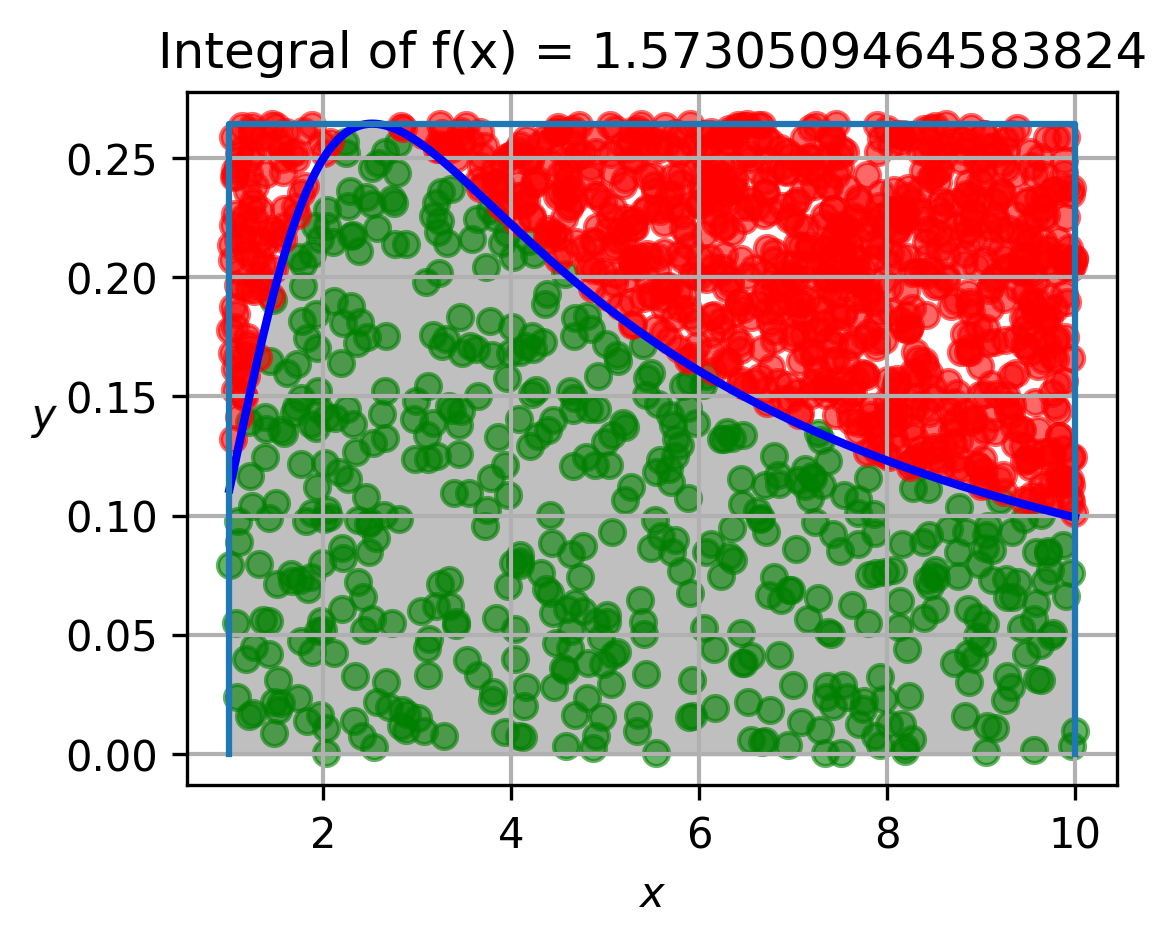

In [23]:
gmci = GraphicMonteCarloIntegral(n, a, b, f)
gmci.plot()